In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement_integral
# from bo_functions import improvement_int_terms

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

print("Model Mean \n", model_mean)
print("Model Variance \n", model_variance)
print("Model Standard Deviation \n", model_stdev)
print("Model y \n", model_y)
print("Y Value Expected \n", y_exp)

Model Mean 
 tensor([ 2.9879, -6.2383, -5.0310, -7.5645, -1.9616, -0.5211],
       dtype=torch.float64)
Model Variance 
 tensor([7.0452, 6.6659, 6.6159, 7.9151, 5.9328, 5.7719], dtype=torch.float64)
Model Standard Deviation 
 tensor([2.6543, 2.5818, 2.5721, 2.8134, 2.4357, 2.4025], dtype=torch.float64)
Model y 
 tensor([ 2.9879, -6.2383, -5.0310, -7.5645, -1.9616, -0.5211],
       dtype=torch.float64)
Y Value Expected 
 [  9.71559339  -6.45322858  -3.26425074 -11.85113203   0.01428989
   1.10146393]


In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
# print("best x",best_x)
# print(test_p[1])
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("Best Error is: ",best_error)
print("EI:",ei)

Upper bound is [ 2.61559945  0.          0.77040401 -1.44729268  0.89942948  0.7648183 ]
Lower bound is [ 2.45368375 -0.16645913  0.60331747 -1.60005222  0.72298593  0.58593261]
pdf upper is [0.0130415  0.39894228 0.29650248 0.13997848 0.26622187 0.29777651]
cdf upper is [0.99554645 0.5        0.77946986 0.07390748 0.81578803 0.77781012]
pdf lower is [0.01965899 0.39345332 0.33256015 0.11091157 0.30718876 0.33601582]
cdf lower is [0.99292994 0.43389782 0.72685124 0.0547935  0.76515574 0.7210396 ]
[0.48390388 0.25       0.35351999 0.07653082 0.3688047  0.35284005]
[0.44979254 0.25       0.12509329 0.27912065 0.12935691 0.12509513]
Best Error is:  0.046175497156527884
EI: [-0.48648773  0.27433811 -0.44418306 -1.34576393 -0.61189811 -0.39670834]


Lower Improvement Integrand is 
 [0. 0. 0. 0. 0. 0.]
Upper Improvement Integrand is 
 [-4.97714683e-18  0.00000000e+00 -2.67461901e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


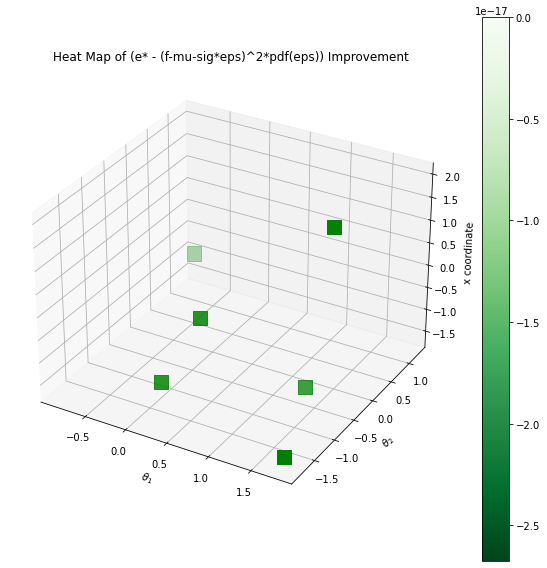

None


In [8]:
Integrand_values = improvement_integral(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )
print(improvement_plot(test_p,Integrand_values))

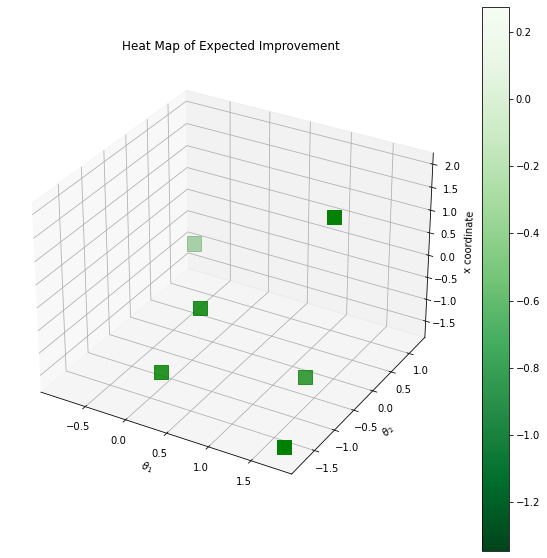

None


In [9]:
print(ei_plotter_adv(test_p, ei))

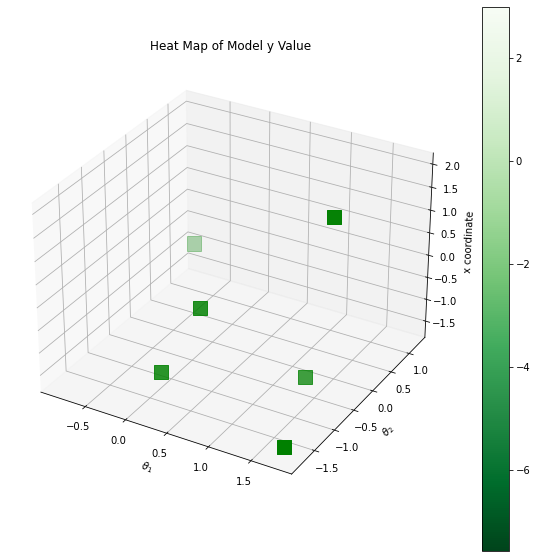

None


In [10]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

In [44]:
import torch
import numpy as np
from scipy.stats import norm

def improvement_int_terms(error_best,pred_mean,pred_var,y_target, steps=5, eps=None): #Needs work
    """ 
    Calculates the improvement integrand of the 3 input parameter GP
    Parameters
    ----------
        error_best: float, the best predicted error encountered
        pred_mean: tensor or ndarray, model mean
        pred_var: tensor or ndarray, model variance
        y_target: tensor or ndarray, the expected value of the function from data or other source
        eps: float or int, The value of a bound
    
    Returns
    -------
        improvement: ndarray, the improvement integrand of the GP model to be plotted. Used for testing
    """    
    #Asserts best_error is a float or integer
    assert isinstance(error_best, (float,int))==True, "error_best must be a float or integer"
    
    #Coverts any tensors given as inputs to ndarrays
    if torch.is_tensor(pred_mean)==True:
        pred_mean = pred_mean.numpy() #1xn
    if torch.is_tensor(pred_var)==True:
        pred_var = pred_var.numpy() #1xn
    if torch.is_tensor(y_target)==True:
        y_target = y_target.numpy() #1xn
    pred_stdev = np.sqrt(pred_var) #1xn
    
    
    I_term_1 = np.zeros((steps,len(y_target)))
    I_term_2 = np.zeros((steps,len(y_target)))
    I_term_3 = np.zeros((steps,len(y_target)))

    if eps == None:
        eps_a = ((y_target - pred_mean) +np.sqrt(error_best))/pred_stdev #1xn
        eps_b = ((y_target - pred_mean) -np.sqrt(error_best))/pred_stdev #1xn
        eps_up = np.zeros(len(eps_a))
        eps_low = np.zeros(len(eps_a))
        
        for i in range(len(eps_a)):
            eps_low[i] = np.min([eps_a[i],eps_b[i]])
            eps_up[i] = np.max([eps_a[i],eps_b[i]])
#         print(eps_up,eps_low)
     
        epsilon_space = np.linspace(eps_low, eps_up, steps)
        for i in range(steps):
            for j in range(len(y_target)):
                term_1  = (error_best - (y_target - pred_mean)**2)*norm.pdf(epsilon_space[i,j])
                term_2 = 2*(y_target - pred_mean)*pred_stdev*epsilon_space[i,j]*norm.pdf(epsilon_space[i,j])
                term_3 = -(pred_var**2)*(epsilon_space[i,j]**2)*norm.pdf(epsilon_space[i,j])
                I_term_1[i] = term_1
                I_term_2[i] = term_2
                I_term_3[i] = term_3
 
    return epsilon_space, I_term_1, I_term_2,I_term_3

improvement_int_terms(best_error,model_mean,model_variance,y_exp)

(array([[ 2.45368375, -0.16645913,  0.60331747, -1.60005222,  0.72298593,
          0.58593261],
        [ 2.49416268, -0.12484435,  0.64508911, -1.56186233,  0.76709682,
          0.63065403],
        [ 2.5346416 , -0.08322956,  0.68686074, -1.52367245,  0.81120771,
          0.67537545],
        [ 2.57512052, -0.04161478,  0.72863238, -1.48548256,  0.8553186 ,
          0.72009687],
        [ 2.61559945,  0.        ,  0.77040401, -1.44729268,  0.89942948,
          0.7648183 ]]),
 array([[-15.19298937,   0.        ,  -1.03326759,  -6.15892835,
          -1.29633336,  -0.86913256],
        [-14.7852543 ,   0.        ,  -1.00553774,  -5.99364086,
          -1.26154359,  -0.8458076 ],
        [-14.3597134 ,   0.        ,  -0.97659691,  -5.82113525,
          -1.22523455,  -0.82146404],
        [-13.91855512,   0.        ,  -0.94659396,  -5.64229867,
          -1.18759296,  -0.79622707],
        [-13.46399508,   0.        ,  -0.91567956,  -5.45802929,
          -1.14880788,  -0.77022344]